In [1]:
!pip install pytorch_lightning

In [2]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path(2)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['src', '.git', 'playground', 'setup', 'README.md', 'hf_wdf.sh', 'freqnet_image.ipynb', 'reports', '__pycache__', 'faceforensics_download.py', 'environment.yml', 'run_jupyter.sh', 'config.py', 'dct_mean_real_fake.png', 'analysis', '.gitignore']


In [3]:
# import local config
import config

In [4]:
from datasets import load_dataset
import numpy as np

In [5]:
import torch

In [6]:
import matplotlib.pyplot as plt

In [7]:
import config
from src.transforms.frequency import fft_amp_phase, dct_coeff, wavelet_subbands

In [8]:
dataset = load_dataset("xingjunm/WildDeepfake", streaming=True, split="test")

Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

In [9]:
from tqdm import tqdm

In [10]:
output_dir = config.ANALYSIS_DIR
os.makedirs(output_dir, exist_ok=True)

In [11]:
real_index = 107003
sample_size = 50000
ep = 0
sampling_interval = 1 # to sample images from different videos using an interval

skip_index = real_index - sample_size * sampling_interval - ep
skipped_dataset = dataset.skip(skip_index)

In [12]:
real_count = 0
fake_count = 0

sampling_interval_count = sampling_interval

img_real_samples = []
img_fake_samples = []

# images
img_real = None
img_fake = None

fft_real = None
fft_fake = None

dct_real = None
dct_fake = None

dwt_real = None
dwt_fake = None

# mean images
fft_mean_real = np.zeros((2, 224, 224))
fft_mean_fake = np.zeros((2, 224, 224))

dct_mean_real = np.zeros((1, 224, 224))
dct_mean_fake = np.zeros((1, 224, 224))

dwt_mean_real = np.zeros((4, 224, 224))
dwt_mean_fake = np.zeros((4, 224, 224))

pbar = tqdm(total=(sample_size*2))

for d in skipped_dataset:
    sampling_interval_count -= 1
    if sampling_interval_count <= 0:
      sampling_interval_count = sampling_interval
    else:
      continue
    # image
    img = d['png']

    # fast fourier transform
    fft_result = fft_amp_phase(img)
    fft_result = fft_result.detach().cpu().numpy()

    # discrete cosine transform
    dct_result = dct_coeff(img)  # Returns a NumPy array
    dct_result = dct_result.detach().cpu().numpy()

    # discrete wavelet transform
    dwt_result = wavelet_subbands(img)
    dwt_result = dwt_result.detach().cpu().numpy()

    if "real" in d["__key__"] and real_count < sample_size:
        real_count += 1
        img_real = img
        # img_real_samples.append(img_real)

        fft_real = fft_result
        fft_mean_real += (fft_result - fft_mean_real) / real_count

        dct_real = dct_result
        dct_mean_real += (dct_result - dct_mean_real) / real_count

        dwt_real = dwt_result
        dwt_mean_real += (dwt_result - dwt_mean_real) / real_count

    elif "fake" in d["__key__"] and fake_count < sample_size:
        fake_count += 1
        img_fake = img
        # img_fake_samples.append(img_fake)

        fft_fake = fft_result
        fft_mean_fake += (fft_result - fft_mean_fake) / fake_count

        dct_fake = dct_result
        dct_mean_fake += (dct_result - dct_mean_fake) / fake_count

        dwt_fake = dwt_result
        dwt_mean_fake += (dwt_result - dwt_mean_fake) / fake_count

    if real_count >=sample_size and fake_count>=sample_size:
      break

    pbar.update(1)

100%|█████████▉| 99995/100000 [33:23<00:00, 55.18it/s]

In [13]:
img_real = np.squeeze(img_real)
img_fake = np.squeeze(img_fake)

fft_real = np.squeeze(fft_real)
fft_fake = np.squeeze(fft_fake)

dct_real = np.squeeze(dct_real)
dct_fake = np.squeeze(dct_fake)

dwt_real = np.squeeze(dwt_real)
dwt_fake = np.squeeze(dwt_fake)

dct_mean_real = np.squeeze(dct_mean_real)
dct_mean_fake = np.squeeze(dct_mean_fake)

In [14]:
print("Real samples:", real_count)
print("Fake samples:", fake_count)

Real samples: 50000
Fake samples: 50000


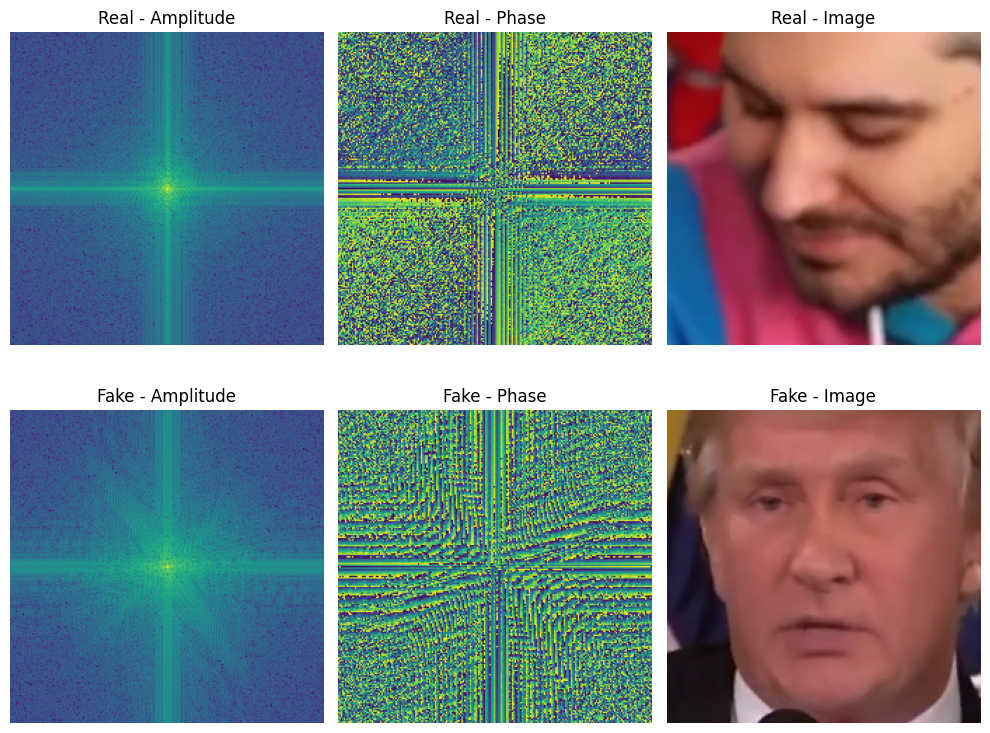

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs[0, 0].imshow(fft_real[0])
axs[0, 0].set_title('Real - Amplitude')
axs[0, 1].imshow(fft_real[1])
axs[0, 1].set_title('Real - Phase')
axs[0, 2].imshow(img_real)
axs[0, 2].set_title('Real - Image')

axs[1, 0].imshow(fft_fake[0])
axs[1, 0].set_title('Fake - Amplitude')
axs[1, 1].imshow(fft_fake[1])
axs[1, 1].set_title('Fake - Phase')
axs[1, 2].imshow(img_fake)
axs[1, 2].set_title('Fake - Image')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/fft_img_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

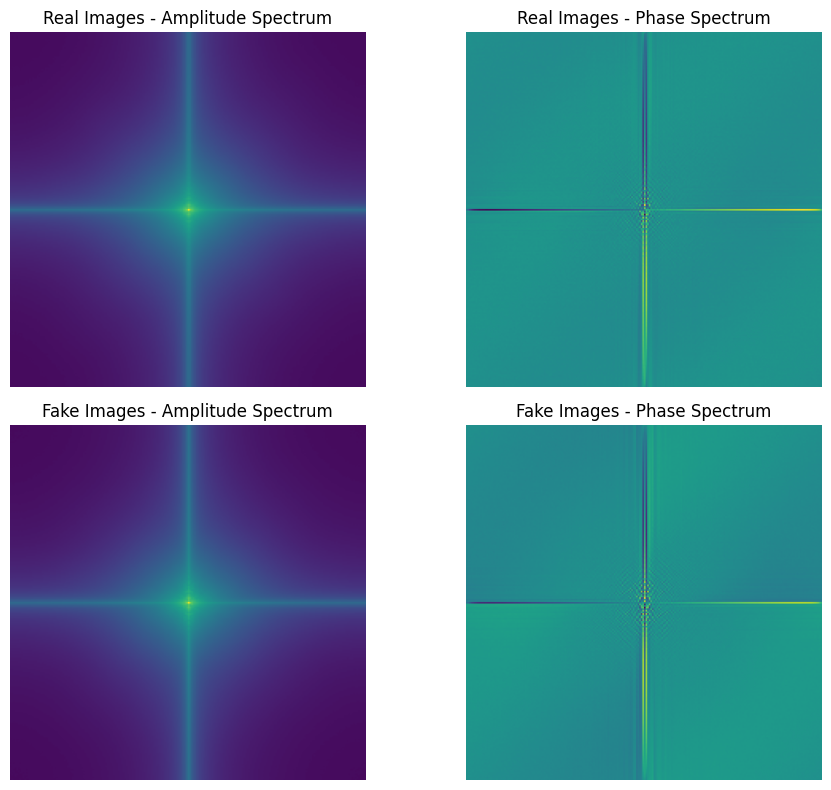

In [16]:
mean_real_amp = fft_mean_real[0]      # Real part for real images
mean_real_phase = fft_mean_real[1]      # Imaginary part for real images
mean_fake_amp = fft_mean_fake[0]      # Real part for fake images
mean_fake_phase = fft_mean_fake[1]      # Imaginary part for fake images

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(mean_real_amp)
axs[0, 0].set_title('Real Images - Amplitude Spectrum')
axs[0, 1].imshow(mean_real_phase)
axs[0, 1].set_title('Real Images - Phase Spectrum')
axs[1, 0].imshow(mean_fake_amp)
axs[1, 0].set_title('Fake Images - Amplitude Spectrum')
axs[1, 1].imshow(mean_fake_phase)
axs[1, 1].set_title('Fake Images - Phase Spectrum')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/fft_mean_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

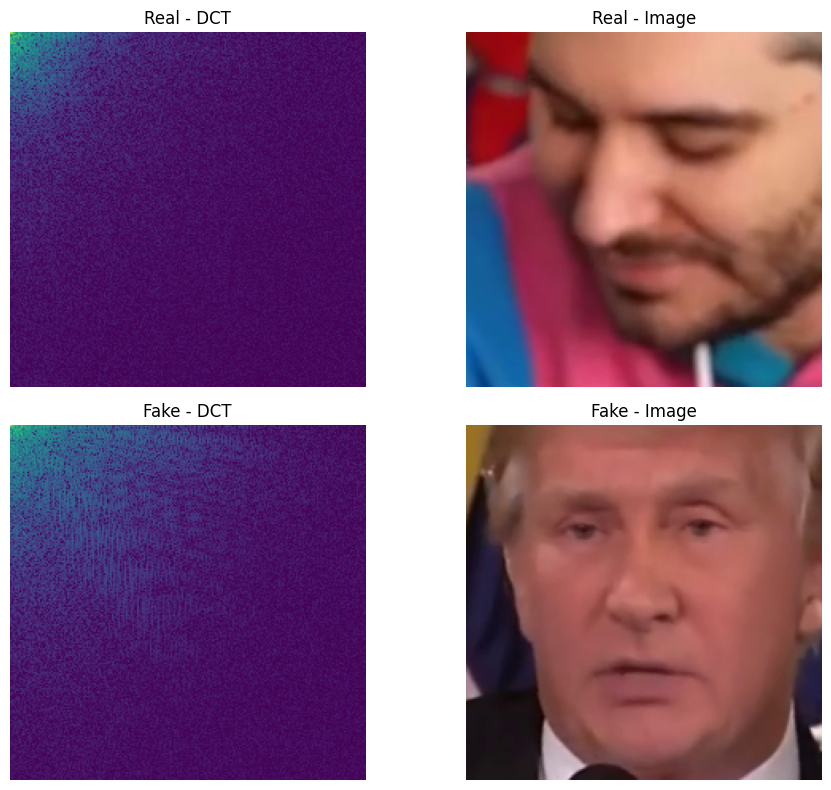

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(dct_real)
axs[0, 0].set_title('Real - DCT')
axs[0, 1].imshow(img_real)
axs[0, 1].set_title('Real - Image')

axs[1, 0].imshow(dct_fake)
axs[1, 0].set_title('Fake - DCT')
axs[1, 1].imshow(img_fake)
axs[1, 1].set_title('Fake - Image')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/dct_img_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

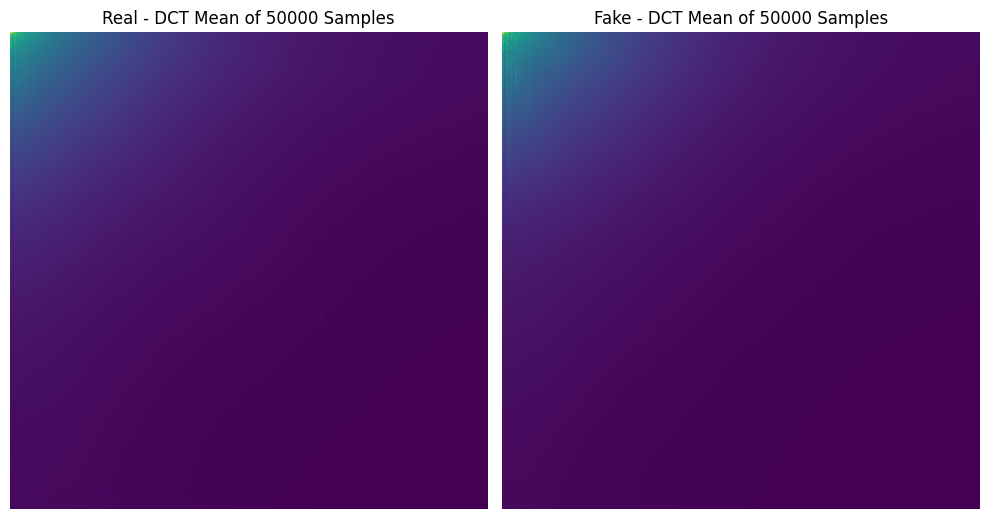

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(dct_mean_real)
axs[0].set_title(f'Real - DCT Mean of {sample_size} Samples')

axs[1].imshow(dct_mean_fake)
axs[1].set_title(f'Fake - DCT Mean of {sample_size} Samples')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/dct_mean_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

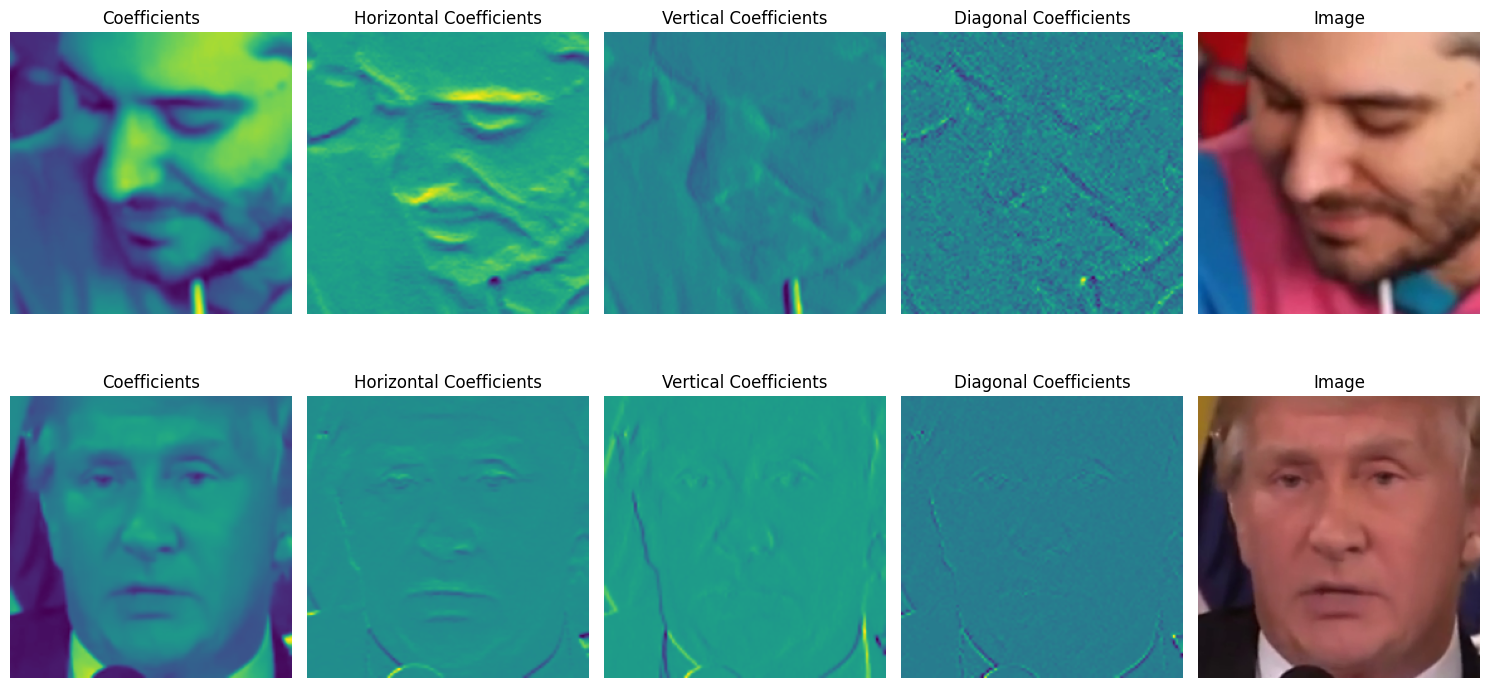

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs[0, 0].imshow(dwt_real[0])
axs[0, 0].set_title('Coefficients')
axs[0, 1].imshow(dwt_real[1])
axs[0, 1].set_title('Horizontal Coefficients')
axs[0, 2].imshow(dwt_real[2])
axs[0, 2].set_title('Vertical Coefficients')
axs[0, 3].imshow(dwt_real[3])
axs[0, 3].set_title('Diagonal Coefficients')
axs[0, 4].imshow(img_real)
axs[0, 4].set_title('Image')

axs[1, 0].imshow(dwt_fake[0])
axs[1, 0].set_title('Coefficients')
axs[1, 1].imshow(dwt_fake[1])
axs[1, 1].set_title('Horizontal Coefficients')
axs[1, 2].imshow(dwt_fake[2])
axs[1, 2].set_title('Vertical Coefficients')
axs[1, 3].imshow(dwt_fake[3])
axs[1, 3].set_title('Diagonal Coefficients')
axs[1, 4].imshow(img_fake)
axs[1, 4].set_title('Image')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/dwt_img_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

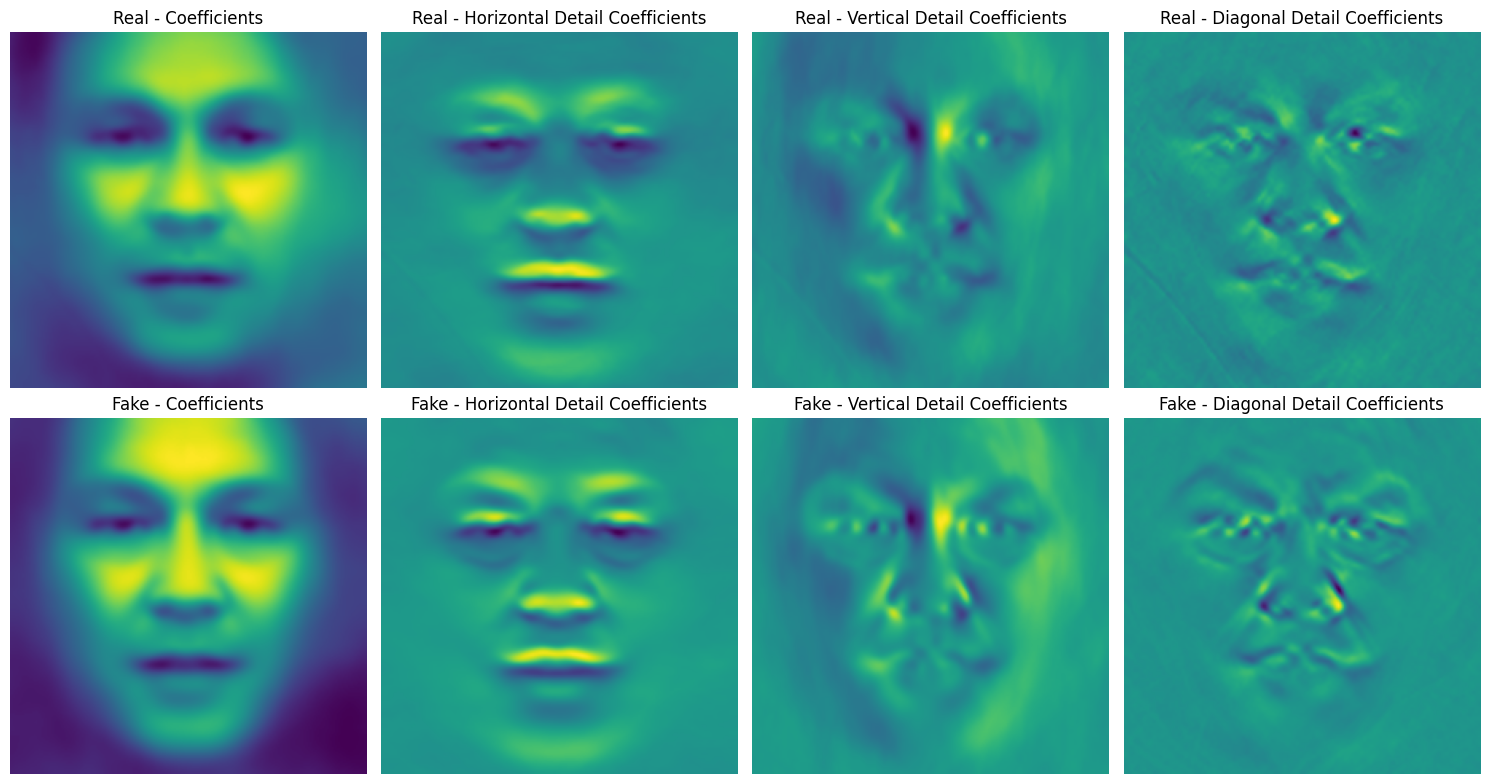

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
axs[0, 0].imshow(dwt_mean_real[0])
axs[0, 0].set_title('Real - Coefficients')
axs[0, 1].imshow(dwt_mean_real[1])
axs[0, 1].set_title('Real - Horizontal Detail Coefficients')
axs[0, 2].imshow(dwt_mean_real[2])
axs[0, 2].set_title('Real - Vertical Detail Coefficients')
axs[0, 3].imshow(dwt_mean_real[3])
axs[0, 3].set_title('Real - Diagonal Detail Coefficients')

axs[1, 0].imshow(dwt_mean_fake[0])
axs[1, 0].set_title('Fake - Coefficients')
axs[1, 1].imshow(dwt_mean_fake[1])
axs[1, 1].set_title('Fake - Horizontal Detail Coefficients')
axs[1, 2].imshow(dwt_mean_fake[2])
axs[1, 2].set_title('Fake - Vertical Detail Coefficients')
axs[1, 3].imshow(dwt_mean_fake[3])
axs[1, 3].set_title('Fake - Diagonal Detail Coefficients')


for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/dwt_mean_img_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# pres_size = 8
# fig, axs = plt.subplots(2, pres_size, figsize=(16, 6))

# for i in range(pres_size):
#   axs[0, i].imshow(img_real_samples[i])
#   # axs.set_ylabel("Real Images", rotation=0, size='large')

#   axs[1, i].imshow(img_fake_samples[i])
#   # axs.set_ylabel("Fake Images", rotation=0, size='large')

#   for ax in axs.ravel():
#       ax.axis('off')

# plt.tight_layout()
# plt.savefig(f'{output_dir}/wilddeepfake_real_fake.png', dpi=300, bbox_inches='tight')
# plt.show()

In [23]:
# from PIL import Image

# # save samples to project for further analyses
# os.makedirs(f'{output_dir}/samples/real', exist_ok=True)
# os.makedirs(f'{output_dir}/samples/fake', exist_ok=True)

# for i, img_array in enumerate(img_real_samples):
#     img_array.save(f'{output_dir}/samples/real/{i}.png')
# for i, img_array in enumerate(img_fake_samples):
#     img_array.save(f'{output_dir}/samples/fake/{i}.png')

In [24]:
type(fft_mean_real)     # Imaginary part for real images
# mean_fake_amp = fft_mean_fake

numpy.ndarray

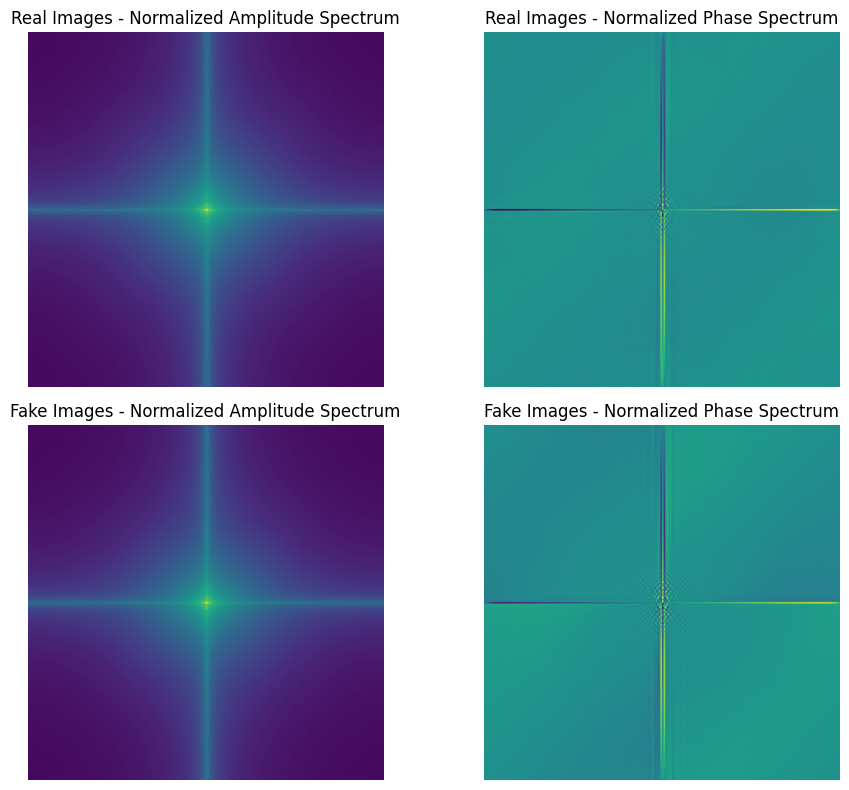

In [25]:
min_value_real = np.min(fft_mean_real)
max_value_real = np.max(fft_mean_real)
normalized_array_real = (fft_mean_real - min_value_real) / (max_value_real - min_value_real)

min_value_fake = np.min(fft_mean_fake)
max_value_fake = np.max(fft_mean_fake)
normalized_array_fake = (fft_mean_fake - min_value_fake) / (max_value_fake - min_value_fake)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(normalized_array_real[0])
axs[0, 0].set_title('Real Images - Normalized Amplitude Spectrum')
axs[0, 1].imshow(normalized_array_real[1])
axs[0, 1].set_title('Real Images - Normalized Phase Spectrum')
axs[1, 0].imshow(normalized_array_fake[0])
axs[1, 0].set_title('Fake Images - Normalized Amplitude Spectrum')
axs[1, 1].imshow(normalized_array_fake[1])
axs[1, 1].set_title('Fake Images - Normalized Phase Spectrum')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/fft_mean_norm_real_fake.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
print("Mean magnitude - real:", np.mean(fft_mean_real[0]))
print("Mean magnitude - fake:", np.mean(fft_mean_fake[0]))
print("Mean phase     - real:", np.mean(fft_mean_real[1]))
print("Mean phase     - fake:", np.mean(fft_mean_fake[1]))

Mean magnitude - real: 0.3283116392538753
Mean magnitude - fake: 0.32406443044412087
Mean phase     - real: 0.49999968167955855
Mean phase     - fake: 0.4999993670583666


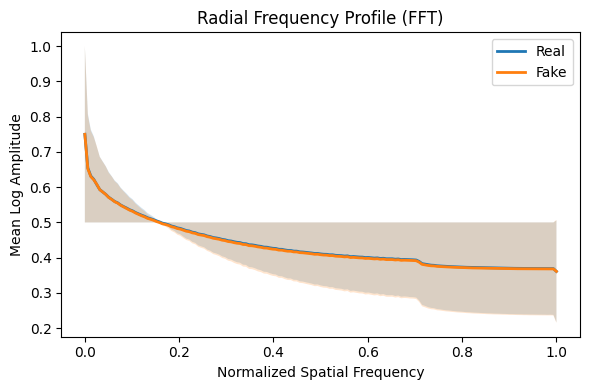

In [27]:
def radial_profile(img_mag):
    """Compute mean FFT magnitude vs. radius."""
    h, w = img_mag.shape
    cy, cx = h // 2, w // 2
    y, x = np.indices((h, w))
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r_int = r.astype(int)
    # mean magnitude at each integer radius
    tbin = np.bincount(r_int.ravel(), img_mag.ravel())
    nr = np.bincount(r_int.ravel())
    radial_mean = tbin / (nr + 1e-9)
    return radial_mean

def average_radial_profile(list_of_mags):
    profiles = [radial_profile(m) for m in list_of_mags]
    # pad shorter ones to same length
    max_len = max(len(p) for p in profiles)
    arr = np.zeros((len(profiles), max_len))
    for i, p in enumerate(profiles):
        arr[i, :len(p)] = p
    return arr.mean(axis=0), arr.std(axis=0)

# Example usage:
real_mean, real_std = average_radial_profile(fft_mean_real)
fake_mean, fake_std = average_radial_profile(fft_mean_fake)

# Normalize radius to 0–1 for plotting
r = np.linspace(0, 1, len(real_mean))

plt.figure(figsize=(6,4))
plt.plot(r, real_mean, label='Real', lw=2)
plt.fill_between(r, real_mean - real_std, real_mean + real_std, alpha=0.2)
plt.plot(r, fake_mean, label='Fake', lw=2)
plt.fill_between(r, fake_mean - fake_std, fake_mean + fake_std, alpha=0.2)
plt.xlabel('Normalized Spatial Frequency')
plt.ylabel('Mean Log Amplitude')
plt.title('Radial Frequency Profile (FFT)')
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
print("Mean DCT - real:", np.mean(dct_mean_real))
print("Mean DCT - fake:", np.mean(dct_mean_fake))

Mean DCT - real: 0.07206765478791659
Mean DCT - fake: 0.06819357329716409


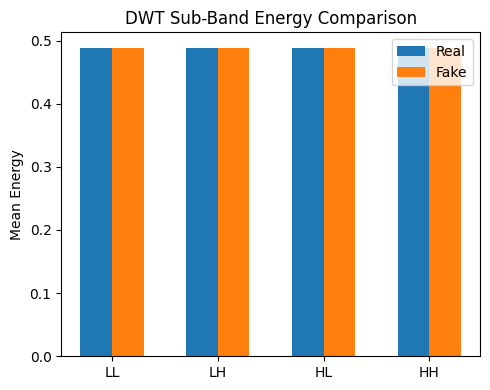

In [29]:
import pywt

def dwt_band_energy(img, wavelet='haar'):
    cA, (cH, cV, cD) = pywt.dwt2(img, wavelet)
    return [np.mean(np.square(cA)),
            np.mean(np.square(cH)),
            np.mean(np.square(cV)),
            np.mean(np.square(cD))]

real_E = np.mean(dwt_mean_real)
fake_E = np.mean(dwt_mean_fake)
bands = ['LL','LH','HL','HH']

plt.figure(figsize=(5,4))
x = np.arange(len(bands))
plt.bar(x-0.15, real_E, width=0.3, label='Real')
plt.bar(x+0.15, fake_E, width=0.3, label='Fake')
plt.xticks(x, bands)
plt.ylabel('Mean Energy')
plt.title('DWT Sub-Band Energy Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
print("Mean DWT - real:", real_E)
print("Mean DWT - fake:", fake_E)

Mean DWT - real: 0.48751574380395324
Mean DWT - fake: 0.4886303812363031
